Import Library

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

Load .env and Setup database connection

In [7]:
#Load environment variables
load_dotenv()

# Get credentials from environment variables
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASS')

# Create a database connection
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

#SQL Query
query = """
SELECT
    c."CustomerID",
    SUM(s."total_amount") AS total_sales,
    COUNT(s."InvoiceNo") AS order_frequency
FROM
    Dim_Customer c
JOIN
    Fact_Sales s ON c."CustomerID" = s."CustomerID"
GROUP BY
    c."CustomerID"
"""

Execute the query and check if the database is successfully connected.

In [8]:
#execute the query into the database
try:
    df = pd.read_sql(query, engine)
    # print the first few rows of the data
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Database connection: {engine}")  #to check the connection
    df = pd.DataFrame()  # Create an empty DataFrame in case of error

   CustomerID  total_sales  order_frequency
0       16592       3958.0              232
1       13527       2117.0              223
2       14173        260.0               25
3       12502       1684.0              100
4       14067        291.0               50


Load the customer_segmentation_model and preprocess data

In [10]:
# Load the saved K-Means model and scaler
k_means = joblib.load('customer_segmentation_model.pkl')
scaler = joblib.load('scaler.pkl')

# Preprocess the data (normalize the features using the saved scaler)
df_scaled = scaler.transform(df[['total_sales', 'order_frequency']])

# Apply the K-Means model to predict clusters for the new data
df['Cluster'] = k_means.predict(df_scaled)

# Inspect the cluster assignments
print("Cluster assignments for new data:")
print(df[['CustomerID', 'total_sales', 'order_frequency', 'Cluster']].head())

Cluster assignments for new data:
   CustomerID  total_sales  order_frequency  Cluster
0       16592       3958.0              232        2
1       13527       2117.0              223        0
2       14173        260.0               25        0
3       12502       1684.0              100        0
4       14067        291.0               50        0


Assign meaningful cluster labels

In [11]:
# Assign meaningful cluster labels based on cluster centers
cluster_centers = k_means.cluster_centers_

# Mapping clusters to meaningful labels
if cluster_centers[0][0] > cluster_centers[1][0]:
    cluster_labels = {
        0: 'High-Value Customers',
        1: 'Low-Value Customers',
        2: 'Moderate-Value Customers'
    }
else:
    cluster_labels = {
        0: 'Low-Value Customers',
        1: 'High-Value Customers',
        2: 'Moderate-Value Customers'
    }

# Map cluster labels to the dataframe
df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Display the updated dataframe with cluster labels
print("\nData with Cluster Labels:")
print(df.head())


Data with Cluster Labels:
   CustomerID  total_sales  order_frequency  Cluster             Cluster Label
0       16592       3958.0              232        2  Moderate-Value Customers
1       13527       2117.0              223        0       Low-Value Customers
2       14173        260.0               25        0       Low-Value Customers
3       12502       1684.0              100        0       Low-Value Customers
4       14067        291.0               50        0       Low-Value Customers


Scatter Plot Visualization

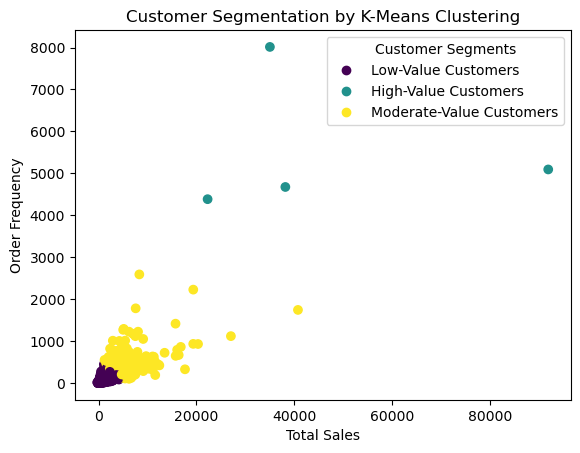

{'data': [{'CustomerID': 16592, 'total_sales': 3958.0, 'order_frequency': 232, 'Cluster Label': 'Moderate-Value Customers'}, {'CustomerID': 13527, 'total_sales': 2117.0, 'order_frequency': 223, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 14173, 'total_sales': 260.0, 'order_frequency': 25, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 12502, 'total_sales': 1684.0, 'order_frequency': 100, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 14067, 'total_sales': 291.0, 'order_frequency': 50, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 17197, 'total_sales': 532.0, 'order_frequency': 24, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 12602, 'total_sales': 161.0, 'order_frequency': 14, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 13093, 'total_sales': 3500.0, 'order_frequency': 123, 'Cluster Label': 'Low-Value Customers'}, {'CustomerID': 13520, 'total_sales': 1917.0, 'order_frequency': 89, 'Cluster Label': 'Low-Value Customers'}, {'Cu

In [12]:
# Visualize the clustering result with color labels (Scatter Plot)
scatter = plt.scatter(df['total_sales'], df['order_frequency'], c=df['Cluster'], cmap='viridis')

# Create a custom legend to show which color corresponds to which cluster
handles, _ = scatter.legend_elements()
legend_labels = [cluster_labels[i] for i in range(3)]
plt.legend(handles, legend_labels, title="Customer Segments")

# Label the axes and title
plt.xlabel('Total Sales')
plt.ylabel('Order Frequency')
plt.title('Customer Segmentation by K-Means Clustering')
plt.show()

# JSON Format for Frontend (for scatter plot)
scatter_data = {
    "data": df[['CustomerID', 'total_sales', 'order_frequency', 'Cluster Label']].to_dict(orient='records'),
    "chart": {
        "type": "scatter",
        "x": "total_sales",
        "y": "order_frequency",
        "color": "Cluster Label",
        "legend": legend_labels
    }
}

print(scatter_data)

Bar Chart Visualization

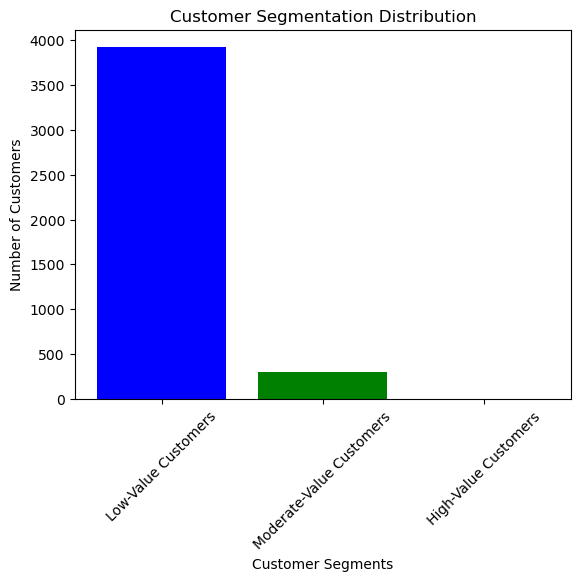

{'data': {'Low-Value Customers': 3913, 'Moderate-Value Customers': 305, 'High-Value Customers': 4}, 'chart': {'type': 'bar', 'x': 'Customer Segments', 'y': 'Number of Customers'}}


In [13]:
# Bar chart for customer segment distribution (Bar Chart)
segment_counts = df['Cluster Label'].value_counts()

# Plot the bar chart
plt.bar(segment_counts.index, segment_counts.values, color=['blue', 'green', 'orange'])
plt.xlabel('Customer Segments')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation Distribution')
plt.xticks(rotation=45)
plt.show()

# JSON Format for Frontend (for bar chart)
bar_chart_data = {
    "data": segment_counts.to_dict(),
    "chart": {
        "type": "bar",
        "x": "Customer Segments",
        "y": "Number of Customers"
    }
}

print(bar_chart_data)

Pie Chart Visualization

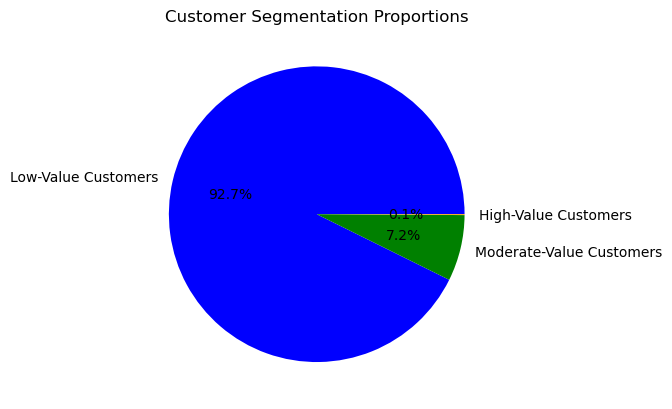

{'data': [{'label': 'Low-Value Customers', 'value': 3913}, {'label': 'Moderate-Value Customers', 'value': 305}, {'label': 'High-Value Customers', 'value': 4}], 'chart': {'type': 'pie', 'labels': 'Customer Segments', 'values': 'Number of Customers'}}


In [14]:
# Pie chart for customer segment distribution (Pie Chart)
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
plt.title('Customer Segmentation Proportions')
plt.show()

# JSON Format for Frontend (for pie chart)
pie_chart_data = {
    "data": [{"label": label, "value": value} for label, value in zip(segment_counts.index, segment_counts.values)],
    "chart": {
        "type": "pie",
        "labels": "Customer Segments",
        "values": "Number of Customers"
    }
}

print(pie_chart_data)